<a href="https://colab.research.google.com/github/tomorn112/ZC-DINO-ER/blob/part3/FlorenceHen_version75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clip for Cracked Egg detection

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install torch
!pip install timm
!pip install flash_attn
!pip install einops

In [ ]:
import copy
import datetime
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import sys
import torch

from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM
%matplotlib inline

In [ ]:
!nvidia-smi

Mon Mar 10 07:20:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             13W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
model_id = 'microsoft/Florence-2-large'

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# Load Florence-2 Model & Processor
import time
start_load_time = time.time()
model_id = "microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().to("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
end_load_time = time.time()

# Calculate total model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Model Parameters: {total_params:,}")

Total Model Parameters: 828,985,344


In [ ]:
def florence2(task_prompt, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer

In [ ]:
def plot_bbox(image, data):
    """
    Plot BBox
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor='lime',
                                 facecolor='none')
        ax.add_patch(rect)
        plt.text(x1,
                 y1,
                 label,
                 color='black',
                 fontsize=8,
                 bbox=dict(facecolor='lime', alpha=1))

    ax.axis('off')
    plt.show()

In [ ]:
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    draw = ImageDraw.Draw(image)
    scale = 1

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = "lime"
        fill_color = "lime" if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    display(image)

In [ ]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.
    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.
    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {'bboxes': bboxes, 'labels': labels}

    return od_results

In [ ]:
def draw_ocr_bboxes(image, prediction):
    """
    Draw OCR BBox
    """
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']

    for box, label in zip(bboxes, labels):
        color = 'lime'
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=4, outline=color)
        draw.text((new_box[0] + 8, new_box[1] + 2),
                  "{}".format(label),
                  align="right",
                  fill=color)

    display(image)

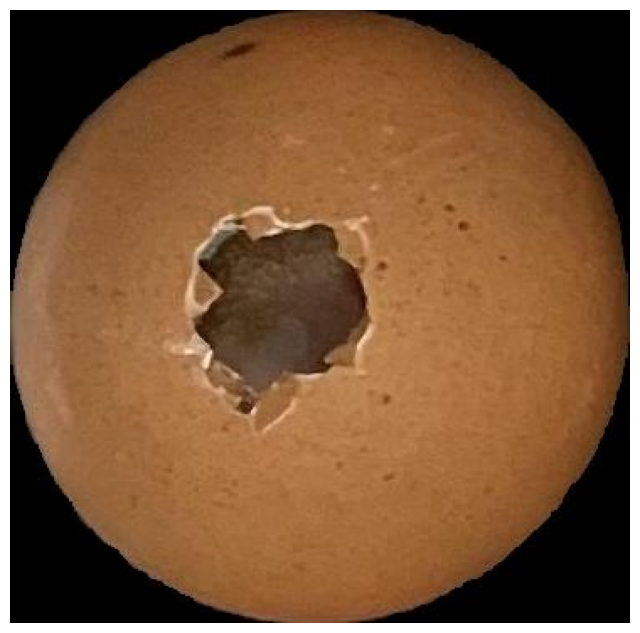

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the image path
image_path = '/content/drive/My Drive/Journal_IJCAS/Egg/dataset/test255/crack/maskegg_0_23.jpg'

# Open the image
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [ ]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="hole and line and tilted")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[124.56800079345703, 124.30599975585938, 128.61599731445312, 122.12199401855469, 131.55999755859375, 121.39399719238281, 136.71200561523438, 121.39399719238281, 139.656005859375, 120.30199432373047, 141.86399841308594, 119.20999908447266, 143.70399475097656, 117.38999938964844, 146.6479949951172, 116.2979965209961, 152.9040069580078, 116.2979965209961, 154.74400329589844, 117.38999938964844, 155.84800720214844, 120.30199432373047, 156.95199584960938, 122.12199401855469, 159.89599609375, 125.39799499511719, 161.7360076904297, 126.1259994506836, 165.04800415039062, 127.2179946899414, 170.93600463867188, 127.2179946899414, 172.0399932861328, 126.1259994506836, 176.08799743652344, 125.39799499511719, 184.1840057373047, 125.39799499511719, 184.9199981689453, 126.1259994506836, 188.23199462890625, 127.2179946899414, 190.07200622558594, 127.2179946899414, 192.27999877929688, 128.30999755859375, 193.01600646972656, 130.1300048828125, 193.0

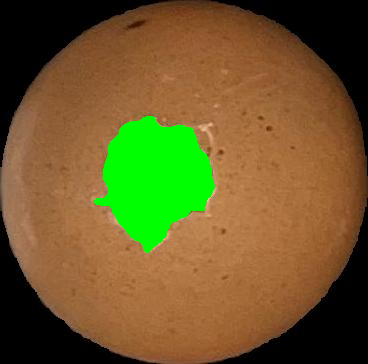

In [ ]:
output_image = copy.deepcopy(image)

draw_polygons(output_image,
              results['<REFERRING_EXPRESSION_SEGMENTATION>'],
              fill_mask=True)

In [ ]:
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import cv2

# Define the image path and save path for binary masks
image_folder_path = '/content/drive/My Drive/Journal_IJCAS/Egg/dataset/test255/crack'
#image_folder_path = '/content/drive/My Drive/Journal_IJCAS/Egg/dataset/train1050/crack'
binary_mask_save_path = '/content/data/binary_mask_1'

# Create the save directory if it doesn't exist
os.makedirs(binary_mask_save_path, exist_ok=True)

# List all files in the folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png') or f.endswith('.jpg')]

# Sort and select the first 5 images
image_files = sorted(image_files)[:113]

def generate_saliency_map(image, mask):
    # Convert the mask from polygon to a binary mask
    binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for polygon in mask['polygons']:
        polygon = np.array(polygon).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(binary_mask, [polygon], 1)

    # Generate a saliency map based on the mask
    saliency_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

    # Increase saliency in the masked region
    saliency_map[binary_mask > 0] = 1.0

    # Apply a Gaussian blur to create a smooth transition
    saliency_map = cv2.GaussianBlur(saliency_map, (21, 21), 0)

    return saliency_map, binary_mask

def overlay_saliency_map(original_image, saliency_map):
    # Normalize saliency map to range [0, 1]
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Convert saliency map to jet colormap
    saliency_map_color = plt.cm.jet(saliency_map)[:, :, :3]  # Ignore alpha channel

    # Convert to PIL Image
    saliency_map_color = (saliency_map_color * 255).astype(np.uint8)
    saliency_map_pil = Image.fromarray(saliency_map_color)

    # Blend original image and saliency map
    original_image = original_image.convert("RGBA")
    saliency_map_pil = saliency_map_pil.convert("RGBA")
    blended_image = Image.blend(original_image, saliency_map_pil, alpha=0.5)

    return blended_image

def plot_images(original_image, processed_image, overlay_image):
    # Display original, processed, and overlay images side by side
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display original image
    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Display processed image
    axs[1].imshow(processed_image)
    axs[1].axis('off')
    axs[1].set_title('Processed Image')

    # Display overlay image
    axs[2].imshow(overlay_image)
    axs[2].axis('off')
    axs[2].set_title('Overlay Image')

    plt.show()

# Process each of the first 5 images
for image_file in image_files:
    # Open the image
    image_path = os.path.join(image_folder_path, image_file)
    image = Image.open(image_path)
    image_np = np.array(image)

    # Task prompt for Florence-2
    task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'

    # Placeholder for florence2 function
    #results = florence2(task_prompt, text_input="hole and line and tilted")
    results = run_example(task_prompt, text_input="hole and line and tilted")

    print("\033[1;31;34m")
    print(results)

    # Create a copy of the image for drawing
    output_image = copy.deepcopy(image)

    # Draw polygons on the image
    mask = results['<REFERRING_EXPRESSION_SEGMENTATION>']
    draw_polygons(output_image, mask, fill_mask=True)

    # Generate saliency map and binary mask
    saliency_map, binary_mask = generate_saliency_map(image_np, mask)

    # Save the binary mask as an image file
    binary_mask_image = Image.fromarray((binary_mask * 255).astype(np.uint8))
    binary_mask_save_file = os.path.join(binary_mask_save_path, f'binary_mask_{image_file}')
    binary_mask_image.save(binary_mask_save_file)

    # Overlay saliency map on the original image
    overlay_image = overlay_saliency_map(image, saliency_map)

    # Plot the images
    #plot_images(image, output_image, overlay_image)


In [ ]:
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import cv2  # Import OpenCV

# Define the image path
image_folder_path = '/content/drive/My Drive/Journal_IJCAS/Egg/dataset/test255/4FL'

# List all files in the folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png') or f.endswith('.jpg')]

# Sort and select the first 113 images
image_files = sorted(image_files)[:113]

def generate_saliency_map(image, mask):
    binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for polygon in mask['polygons']:
        polygon = np.array(polygon).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(binary_mask, [polygon], 1)

    saliency_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    saliency_map[binary_mask > 0] = 1.0
    saliency_map = cv2.GaussianBlur(saliency_map, (21, 21), 0)

    return saliency_map, binary_mask

def overlay_saliency_map(original_image, saliency_map):
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    saliency_map_color = plt.cm.jet(saliency_map)[:, :, :3]  # Ignore alpha channel
    saliency_map_color = (saliency_map_color * 255).astype(np.uint8)
    saliency_map_pil = Image.fromarray(saliency_map_color)
    original_image = original_image.convert("RGBA")
    saliency_map_pil = saliency_map_pil.convert("RGBA")
    return Image.blend(original_image, saliency_map_pil, alpha=0.5)

def plot_images(image_filename, original_image, processed_image, overlay_image):
    # Print filename before displaying the image
    print(f"\033[1;34mProcessing File:\033[0m {image_filename}")  # ANSI escape for blue text

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(processed_image)
    axs[1].axis('off')
    axs[1].set_title('Processed Image')

    axs[2].imshow(overlay_image)
    axs[2].axis('off')
    axs[2].set_title('Overlay Image')

    plt.show()

# Define the output folder for binary masks
output_folder = '/content/data/binary_masks_2'
os.makedirs(output_folder, exist_ok=True)

# Process each of the first 113 images
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    image = Image.open(image_path)
    image_np = np.array(image)

    # Print the filename before processing
    print(f"\033[1;32mProcessing:\033[0m {image_file}")  # Green color for filename

    # Task prompt for Florence-2
    task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'

    # Placeholder for florence2 function
    results = run_example(task_prompt, text_input="hole and line and tilted")
    print("\033[1;31;34m")  # ANSI color escape sequence
    print(results)

    output_image = copy.deepcopy(image)

    mask = results['<REFERRING_EXPRESSION_SEGMENTATION>']
    draw_polygons(output_image, mask, fill_mask=True)

    saliency_map, binary_mask = generate_saliency_map(image_np, mask)

    binary_mask_path = os.path.join(output_folder, f'binary_mask_{image_file}')
    cv2.imwrite(binary_mask_path, (binary_mask * 255).astype(np.uint8))

    overlay_image = overlay_saliency_map(image, saliency_map)

    # ✅ Print filename before displaying images
    plot_images(image_file, image, output_image, overlay_image)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

def calculate_saliency_score(binary_mask):
    if not isinstance(binary_mask, np.ndarray):
        binary_mask = np.array(binary_mask)
    white_pixel_count = np.sum(binary_mask == 255)
    total_pixels = binary_mask.size
    saliency_score = white_pixel_count / total_pixels
    return saliency_score

# Directory paths
image_dir_intact = "/content/drive/My Drive/Journal_IJCAS/Egg/dataset/test255/crack"  # Adjust to your image directory
binary_mask_dir = '/content/data/binary_mask_1'  # Adjust to your binary masks directory

# List files in the intact directory for debugging
print("Files in intact image directory:")
intact_files = sorted(os.listdir(image_dir_intact))
print(intact_files)

# List files in the binary mask directory for debugging
print("Files in binary mask directory:")
binary_mask_files = sorted(os.listdir(binary_mask_dir))
print(binary_mask_files)

# Compile a regex pattern to match binary mask filenames
binary_mask_pattern = re.compile(r'binary_mask_maskegg_(\d+)_(\d+)\.jpg')

# Dictionary to hold the mapping from original image index to binary mask file
binary_mask_dict = {}
for filename in binary_mask_files:
    match = binary_mask_pattern.match(filename)
    if match:
        idx1, idx2 = match.groups()
        binary_mask_dict[(int(idx1), int(idx2))] = filename

# Range of images to display (adjusted to available files)
start_index = 0
end_index = 19  # Adjusted to focus on available files for testing

# Prepare figure
fig, ax = plt.subplots(nrows=end_index - start_index + 1, ncols=2, figsize=(10, 4 * (end_index - start_index + 1)))
ax = ax.flatten()

for i in range(start_index, end_index + 1):
    # Use the actual file names from the directory
    original_image_path_intact = os.path.join(image_dir_intact, intact_files[i])

    # Find the corresponding binary mask file
    binary_mask_filename = binary_mask_dict.get((i, start_index + 21))
    if binary_mask_filename:
        binary_mask_path = os.path.join(binary_mask_dir, binary_mask_filename)
    else:
        print(f"No binary mask found for index {i}")
        continue

    # Load the original image
    original_image = cv2.imread(original_image_path_intact)

    # Load the binary mask
    binary_mask = cv2.imread(binary_mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the binary mask is loaded properly
    if binary_mask is None:
        print(f"Error reading binary mask {binary_mask_path}")
        continue

    # Check if the original image is loaded properly
    if original_image is None:
        print(f"Error reading image {original_image_path_intact}")
        continue

    # Calculate the saliency score
    saliency_score = calculate_saliency_score(binary_mask)

    # Display original image
    ax[(i - start_index) * 2].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    ax[(i - start_index) * 2].axis('off')

    # Display binary mask with saliency score
    ax[(i - start_index) * 2 + 1].imshow(binary_mask, cmap='gray')
    ax[(i - start_index) * 2 + 1].axis('off')
    ax[(i - start_index) * 2 + 1].text(5, 25, f'Saliency Score: {saliency_score:.2f}', color='white', backgroundcolor='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


Accuracy: 0.8431372549019608
Precision: 0.900990099009901
Recall: 0.8053097345132744
F1 Score: 0.8504672897196262


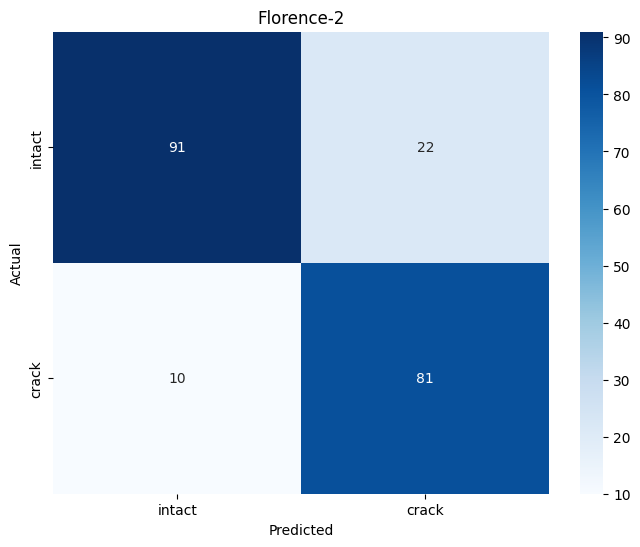

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

def calculate_saliency_score(binary_mask):
    if not isinstance(binary_mask, np.ndarray):
        binary_mask = np.array(binary_mask)
    white_pixel_count = np.sum(binary_mask == 255)
    total_pixels = binary_mask.size
    saliency_score = white_pixel_count / total_pixels
    return saliency_score

# Ground truth labels based on folder names
def get_ground_truth_labels(image_paths, category):
    labels = []
    for path in image_paths:
        if category in path.lower():
            labels.append(category)
        else:
            labels.append('intact' if category == 'crack' else 'crack')
    return labels

# Directory paths
binary_mask_dir1 = '/content/data/binary_mask_1'  # Ground truth: crack
binary_mask_dir2 = '/content/data/binary_masks_2'  # Ground truth: intact

# Load filenames from both directories
binary_mask_files1 = sorted(os.listdir(binary_mask_dir1))
binary_mask_files2 = sorted(os.listdir(binary_mask_dir2))

# Combine file lists and create full paths
binary_mask_files = [(os.path.join(binary_mask_dir1, f), 'crack') for f in binary_mask_files1] + \
                    [(os.path.join(binary_mask_dir2, f), 'intact') for f in binary_mask_files2]

# Generate ground truth labels
ground_truth_labels = [label for _, label in binary_mask_files]

# Define threshold for classification
threshold = 0.005  # Saliency score threshold

predicted_labels = []

for image_path, category in binary_mask_files:
    # Load the binary mask
    binary_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the binary mask is loaded properly
    if binary_mask is None:
        print(f"Error reading binary mask {image_path}")
        continue

    # Calculate the saliency score
    saliency_score = calculate_saliency_score(binary_mask)

    # Classify based on the threshold
    if saliency_score > threshold:
        predicted_labels.append('crack')
    else:
        predicted_labels.append('intact')

# Calculate metrics
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
precision = precision_score(ground_truth_labels, predicted_labels, pos_label='crack')
recall = recall_score(ground_truth_labels, predicted_labels, pos_label='crack')
f1 = f1_score(ground_truth_labels, predicted_labels, pos_label='crack')
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Display results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['intact', 'crack'], yticklabels=['intact', 'crack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Florence-2')
plt.show()


# Performace usage

Processing: Copy of maskegg_0_21.jpg
Inference Time for Copy of maskegg_0_21.jpg: 1.7786 seconds


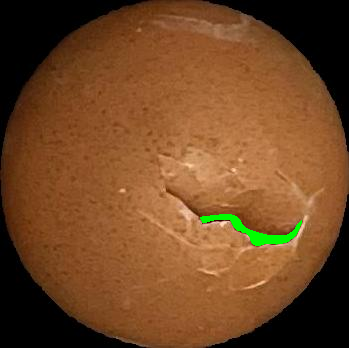

Processing: Copy of maskegg_10_21.jpg
Inference Time for Copy of maskegg_10_21.jpg: 3.2972 seconds


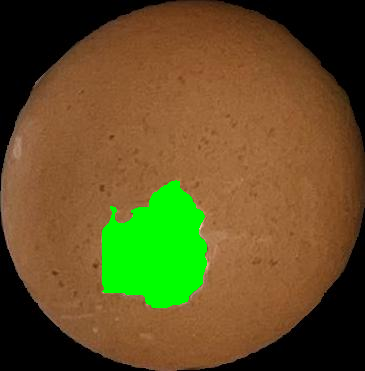

Processing: Copy of maskegg_12_28.jpg
Inference Time for Copy of maskegg_12_28.jpg: 2.7625 seconds


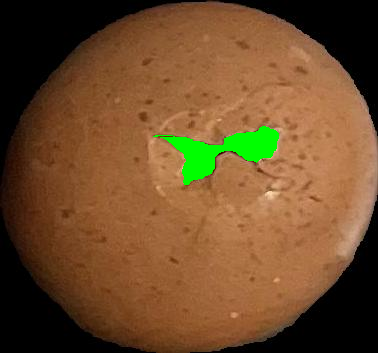

Processing: Copy of maskegg_14_29.jpg
Inference Time for Copy of maskegg_14_29.jpg: 5.3844 seconds


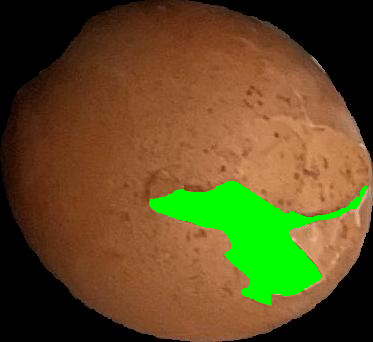

Processing: maskegg_0.jpg
Inference Time for maskegg_0.jpg: 1.2837 seconds


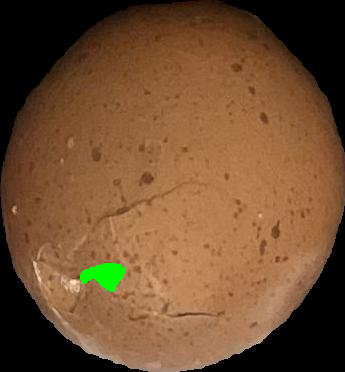

Processing: maskegg_0_21.jpg
Inference Time for maskegg_0_21.jpg: 1.8561 seconds


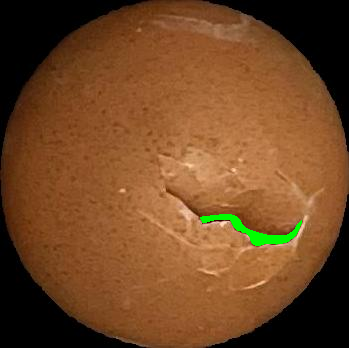

Processing: maskegg_0_23.jpg
Inference Time for maskegg_0_23.jpg: 3.5045 seconds


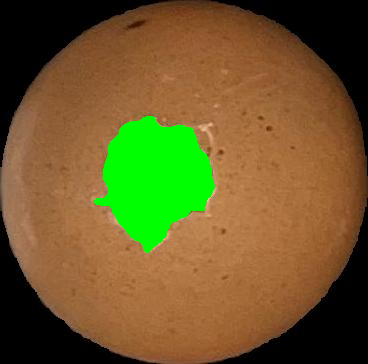

Processing: maskegg_0_26.jpg
Inference Time for maskegg_0_26.jpg: 2.3059 seconds


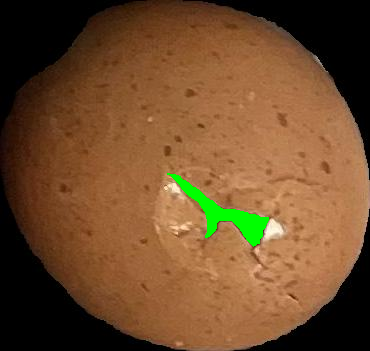

Processing: maskegg_0_27.jpg
Inference Time for maskegg_0_27.jpg: 1.1832 seconds


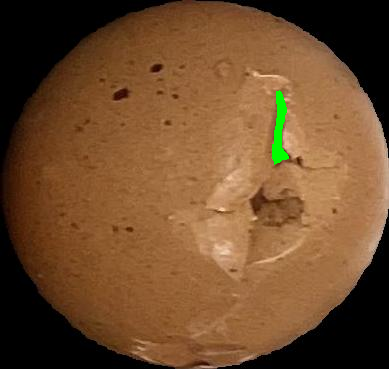

Processing: maskegg_0_28.jpg
Inference Time for maskegg_0_28.jpg: 2.1747 seconds


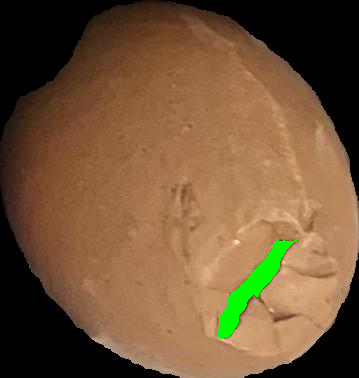


--- Performance Metrics ---
Total Inference Time: 25.5309 seconds
Frames Per Second (FPS): 0.39
CPU Usage Before: 0.60%, After: 1.00%
RAM Usage Increase: -0.0242 GB
GPU Memory Increase: 0.0000 GB
GPU Utilization Increase: 0.00%


In [ ]:
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import cv2
import time
import torch
import psutil
import pynvml  # GPU monitoring

# Define the image path and save path for binary masks
image_folder_path = '/content/drive/My Drive/Journal_IJCAS/Egg/dataset/test255/crack'
binary_mask_save_path = '/content/data/binary_mask_1'

# Create the save directory if it doesn't exist
os.makedirs(binary_mask_save_path, exist_ok=True)

# List all files in the folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png') or f.endswith('.jpg')]

# Sort and select the first 10 images
image_files = sorted(image_files)[:10]

# Initialize Performance Tracking
cpu_usage_before = psutil.cpu_percent(interval=1)
ram_usage_before = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB
gpu_mem_before = gpu_util_before = 0

if torch.cuda.is_available():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    gpu_mem_before = torch.cuda.memory_allocated("cuda") / (1024 ** 3)
    gpu_util_before = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu

# Start Timing for Inference
start_time = time.time()

def generate_saliency_map(image, mask):
    binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for polygon in mask.get('polygons', []):
        polygon = np.array(polygon).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(binary_mask, [polygon], 1)

    saliency_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    saliency_map[binary_mask > 0] = 1.0
    saliency_map = cv2.GaussianBlur(saliency_map, (21, 21), 0)

    return saliency_map, binary_mask

def overlay_saliency_map(original_image, saliency_map):
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    saliency_map_color = plt.cm.jet(saliency_map)[:, :, :3]  # Ignore alpha channel
    saliency_map_color = (saliency_map_color * 255).astype(np.uint8)
    saliency_map_pil = Image.fromarray(saliency_map_color)
    original_image = original_image.convert("RGBA")
    saliency_map_pil = saliency_map_pil.convert("RGBA")
    return Image.blend(original_image, saliency_map_pil, alpha=0.5)

# Process images
total_inference_time = 0
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    image = Image.open(image_path)
    image_np = np.array(image)

    # Print the filename before processing
    print(f"\033[1;32mProcessing:\033[0m {image_file}")  # Green color for filename

    # Task prompt for Florence-2
    task_prompt = "<REFERRING_EXPRESSION_SEGMENTATION>"

    # Start measuring inference time for this image
    image_start_time = time.time()

    # Placeholder for florence2 function (Replace with actual function)
    results = run_example(task_prompt, text_input="hole and line and tilted")

    image_inference_time = time.time() - image_start_time
    total_inference_time += image_inference_time

    print(f"\033[1;34mInference Time for {image_file}: {image_inference_time:.4f} seconds\033[0m")  # Blue text

    output_image = copy.deepcopy(image)
    mask = results['<REFERRING_EXPRESSION_SEGMENTATION>']
    draw_polygons(output_image, mask, fill_mask=True)

    saliency_map, binary_mask = generate_saliency_map(image_np, mask)

    binary_mask_path = os.path.join(binary_mask_save_path, f'binary_mask_{image_file}')
    cv2.imwrite(binary_mask_path, (binary_mask * 255).astype(np.uint8))

    overlay_image = overlay_saliency_map(image, saliency_map)

# End Timing
end_time = time.time()
inference_time = end_time - start_time
fps = len(image_files) / inference_time if inference_time > 0 else float('inf')

# Performance Tracking: End
cpu_usage_after = psutil.cpu_percent(interval=1)
ram_usage_after = psutil.virtual_memory().used / (1024 ** 3)
ram_usage_diff = ram_usage_after - ram_usage_before
gpu_mem_after = gpu_util_after = 0

if torch.cuda.is_available():
    gpu_mem_after = torch.cuda.memory_allocated("cuda") / (1024 ** 3)
    gpu_util_after = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu
    pynvml.nvmlShutdown()

gpu_mem_diff = gpu_mem_after - gpu_mem_before
gpu_util_diff = gpu_util_after - gpu_util_before

# Print Performance Metrics
print("\n--- Performance Metrics ---")
print(f"Total Inference Time: {total_inference_time:.4f} seconds")
print(f"Frames Per Second (FPS): {fps:.2f}")
print(f"CPU Usage Before: {cpu_usage_before:.2f}%, After: {cpu_usage_after:.2f}%")
print(f"RAM Usage Increase: {ram_usage_diff:.4f} GB")
print(f"GPU Memory Increase: {gpu_mem_diff:.4f} GB")
print(f"GPU Utilization Increase: {gpu_util_diff:.2f}%")
